In [294]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate
from scipy.stats import ttest_rel,ttest_ind

# Import your Experiment class and related entities
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [295]:
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30          # Hz
PRE_TIME_S = 5.0         # seconds before grooming onset
POST_EXTRA_S = 5.0       # seconds after the LONGEST bout
MIN_BOUT_S = 1.0   # seconds; exclude bouts shorter than this
MAX_BOUT_S = 30.0  # exclude bouts longer than this (seconds); set None to disable
FIGSIZE = (10, 7)
# End-aligned heatmap window (seconds around bout end)
END_ALIGN_PRE_S = 10.0    # seconds before bout end
END_ALIGN_POST_S = 10.0   # seconds after bout end

Heatmap color scale control:

In [296]:
# - set both to None for automatic scaling per-plot
# - or set numeric values (e.g., -3, 3)
VMIN = None
VMAX = None

# Optional: if True and VMIN/VMAX are None, use a shared scale across WT+KO
USE_SHARED_AUTOSCALE = True
AUTOSCALE_PERCENTILES = (2, 98)  # robust scale, ignores extreme outliers

In [297]:
# Windows in seconds:
# (label, anchor, t_start, t_end)
# anchor: "start" or "end"
WINDOWS = [
    ("5sec Pre-Bout Start",     "start", -5,  0),
    ("5sec Post-Bout Start",    "start",  0,  5),
    ("5sec Post-Bout End",      "end",    0,  5),
    ("10sec Post-Bout End",     "end",    5, 10),
    ("20sec Post-Bout End",     "end",    15, 20),
]

# END-aligned windows in seconds, relative to bout END (t=0 at end_frame)
# END_WINDOWS = [
#     ("End: -10 to -5", "end", -10, -5),
#     ("End: -5 to 0",   "end",  -5,  0),
#     ("End: 0 to 5",    "end",   0,  5),
#     ("End: 5 to 10",   "end",   5, 10),
# ]

END_WINDOWS = [
    ("End: -10 to -7.5", "end", -10.0, -7.5),
    ("End: -7.5 to -5",  "end",  -7.5, -5.0),
    ("End: -5 to -2.5",  "end",  -5.0, -2.5),
    ("End: -2.5 to 0",   "end",  -2.5,  0.0),
    ("End: 0 to 2.5",    "end",   0.0,  2.5),
    ("End: 2.5 to 5",    "end",   2.5,  5.0),
    ("End: 5 to 7.5",    "end",   5.0,  7.5),
    ("End: 7.5 to 10",   "end",   7.5, 10.0),
]



IO

In [298]:
def load_experiments(folder: str):
    exps = []
    for fn in os.listdir(folder):
        if not fn.endswith(".pkl"):
            continue
        path = os.path.join(folder, fn)
        with open(path, "rb") as f:
            obj = pickle.load(f)
        exps.append(obj)
    return exps

GROUPING: collapse composite genotype to Sapap WT vs KO

In [299]:
def group_by_sapap_wt_ko(exps):
    """
    Your genotype strings look like:
      'Sapap(KO); CRH(Hetro)' etc.

    We collapse them into:
      WT if contains 'SAPAP(WT)'
      KO if contains 'SAPAP(KO)'
    """
    groups = {"WT": [], "KO": []}

    for exp in exps:
        geno = getattr(exp, "genotype", getattr(exp, "Genotype", "Unknown"))
        s = str(geno).strip().upper()

        if "SAPAP(WT)" in s:
            groups["WT"].append(exp)
        elif "SAPAP(KO)" in s:
            groups["KO"].append(exp)
        else:
            print(f"Warning: could not classify genotype -> {geno}")

    # drop empties
    groups = {k: v for k, v in groups.items() if len(v)}
    return groups



ADAPTERS: bout frames + neural trace

In [300]:
def get_bouts_frames(exp):
    """
    Return list of (start_frame, end_frame) for grooming bouts
    using RAW grooming annotations only.
    """

    # Explicitly use Grooming_annotations property
    if hasattr(exp, "Grooming_annotations"):
        bouts = exp.Grooming_annotations
        out = []

        for b in bouts:
            # tuple/list
            if isinstance(b, (tuple, list)) and len(b) >= 2:
                out.append((int(b[0]), int(b[1])))
                continue

            # dict
            if isinstance(b, dict):
                s = b.get("Starting frame", b.get("start", b.get("start_frame")))
                e = b.get("Ending frame", b.get("end", b.get("end_frame")))
                if s is not None and e is not None:
                    out.append((int(s), int(e)))
                continue

            raise TypeError(f"Unknown bout format: {type(b)} -> {b}")

        return out

    raise AttributeError(
        "Grooming_annotations not found on Experiment object."
    )


def get_zscore_trace(exp):
    """
    Return 1D numpy array of z-scored neural activity.

    Tries:
      1) precomputed z-score on exp
      2) precomputed z-score on exp.GCaMP_data
      3) compute z-score from a dF/F-like 1D trace on exp.GCaMP_data
    """
    # 1) precomputed on Experiment
    for attr in ["GCaMP_zscore", "zscore", "z_score", "zscored", "GCaMP_z"]:
        if hasattr(exp, attr):
            arr = getattr(exp, attr)
            if arr is not None:
                arr = np.asarray(arr, dtype=float).squeeze()
                if arr.ndim == 1:
                    return arr

    gd = getattr(exp, "GCaMP_data", None)
    if gd is not None:
        # 2) precomputed on GCaMP_data
        for attr in ["GCaMP_zscore", "zscore", "z_score", "zscored", "GCaMP_z"]:
            if hasattr(gd, attr):
                arr = getattr(gd, attr)
                if arr is not None:
                    arr = np.asarray(arr, dtype=float).squeeze()
                    if arr.ndim == 1:
                        return arr

        # 3) compute from candidate raw/processed traces
        candidates = [
            "GCaMP_dF_F_values",
            "dFF",
            "dff",
            "dF_F",
            "dFoverF",
            "df_f",
            "GCaMP_dF_F",
            "signal",
            "values",
            "trace",
        ]
        for name in candidates:
            if hasattr(gd, name):
                x = getattr(gd, name)
                if x is None:
                    continue
                x = np.asarray(x, dtype=float).squeeze()
                if x.ndim != 1:
                    continue
                mu = np.nanmean(x)
                sd = np.nanstd(x)
                sd = sd if sd > 1e-12 else 1.0
                return (x - mu) / sd

    # Helpful debug info if it fails
    gd_attrs = []
    if gd is not None:
        gd_attrs = [a for a in dir(gd) if any(k in a.lower() for k in ["df", "z", "trace", "sig", "val"])]
        gd_attrs = gd_attrs[:80]

    raise AttributeError(
        "Could not find a usable neural trace for z-scoring.\n"
        f"GCaMP_data exists: {gd is not None}\n"
        f"Candidate GCaMP_data attrs (subset): {gd_attrs}"
    )

def bout_window_mean(z, s_frame, e_frame, fr, anchor, t0, t1):
    """
    Mean z-score in a time window relative to bout start or end.
    Returns np.nan if the window is out of bounds or empty.
    """
    if anchor == "start":
        anchor_frame = s_frame
    elif anchor == "end":
        anchor_frame = e_frame
    else:
        raise ValueError("anchor must be 'start' or 'end'")

    a = int(round(anchor_frame + t0 * fr))
    b = int(round(anchor_frame + t1 * fr))

    # guard
    if b <= a:
        return np.nan
    if b <= 0 or a >= len(z):
        return np.nan

    a = max(0, a)
    b = min(len(z), b)
    seg = z[a:b]
    if seg.size == 0:
        return np.nan
    return float(np.nanmean(seg))


def summarize_activity_by_windows(exps, fr, windows, min_bout_s=0.0):
    """
    Compute mean NA (z-score) in each window, using mice as n.

    Returns:
      summary: dict window_label -> dict(mean, sem, n, unit)
      per_mouse: dict window_label -> np.array of per-mouse means (for stats)
    """
    min_bout_n = int(round(min_bout_s * fr))

    # mouse_id -> window_label -> list of per-bout window means
    bucket = {}

    for exp in exps:
        z = get_zscore_trace(exp)
        bouts = get_bouts_frames(exp)

        mouse_id = getattr(exp, "Mouse_id", getattr(exp, "mouse_id", "Unknown"))

        if mouse_id not in bucket:
            bucket[mouse_id] = {w[0]: [] for w in windows}

        for s, e in bouts:
            s = int(s); e = int(e)
            if e <= s:
                continue
            if (e - s) < min_bout_n:
                continue

            for (label, anchor, t0, t1) in windows:
                val = bout_window_mean(z, s, e, fr, anchor, t0, t1)
                if not np.isnan(val):
                    bucket[mouse_id][label].append(val)

    # Build per-mouse mean vectors and summary stats
    summary = {}
    per_mouse = {}

    for (label, _, _, _) in windows:
        mouse_means = []
        for mouse_id, d in bucket.items():
            arr = np.asarray(d[label], dtype=float)
            if arr.size == 0:
                continue
            m = np.nanmean(arr)
            if not np.isnan(m):
                mouse_means.append(m)

        mouse_means = np.asarray(mouse_means, dtype=float)
        per_mouse[label] = mouse_means

        n = int(mouse_means.size)
        mean = float(np.nanmean(mouse_means)) if n else np.nan
        sem = float(np.nanstd(mouse_means, ddof=1) / np.sqrt(n)) if n > 1 else np.nan

        summary[label] = {"mean": mean, "sem": sem, "n": n, "unit": "mice"}

    return summary, per_mouse


def print_window_summary(group_label, summary_dict):
    print(f"\n{group_label} windowed NA summary ({next(iter(summary_dict.values()))['unit']} as n)")
    for k, v in summary_dict.items():
        mean, sem, n = v["mean"], v["sem"], v["n"]
        if np.isnan(mean):
            print(f"  {k}: n={n} | mean=nan | sem=nan")
        else:
            print(f"  {k}: n={n} | mean={mean:.3f} | sem={sem:.3f}")


def compare_groups(per_mouse_WT, per_mouse_KO, alpha=0.05):
    print("\nWT vs KO (Welch t-test)")
    for k in per_mouse_WT:
        a = per_mouse_WT[k]
        b = per_mouse_KO[k]

        if len(a) < 2 or len(b) < 2:
            print(f"  {k}: not enough data")
            continue

        t, p = ttest_ind(a, b, equal_var=False)
        if p < 0.05:
            tag = "  *Significant*"
        elif p < 0.1:
            tag = "  ~Almost significant~"
        else:
            tag = ""

        print(f"  {k}: WT={np.mean(a):.3f}, KO={np.mean(b):.3f}, p={p:.4g}{tag}")




def compare_within_group(per_mouse, ref_window, group_label, alpha=0.05):
    print(f"\nWithin-group comparisons ({group_label}) vs {ref_window}")
    ref = per_mouse[ref_window]

    for k, vals in per_mouse.items():
        if k == ref_window:
            continue

        if len(vals) != len(ref):
            print(f"  {k}: mismatched mice")
            continue

        t, p = ttest_rel(ref, vals)

        if p < 0.05:
            tag = "  *Significant*"
        elif p < 0.1:
            tag = "  ~Almost significant~"
        else:
            tag = ""

        print(f"  {k} vs {ref_window}: Δ={np.mean(vals-ref):.3f}, p={p:.4g}{tag}")




def bout_length_summary(exps, fr, min_bout_s=0.0, max_bout_s=None):
    """
    Counts bouts in bins: 0–2, 2–6, 6–10, ≥10 sec
    using the same min/max filters you use elsewhere.
    """
    min_n = int(round(min_bout_s * fr))
    max_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    lengths_s = []
    for exp in exps:
        for s, e in get_bouts_frames(exp):
            s = int(s); e = int(e)
            if e <= s:
                continue
            dur_n = e - s
            if dur_n < min_n:
                continue
            if max_n is not None and dur_n > max_n:
                continue
            lengths_s.append(dur_n / fr)

    lengths_s = np.asarray(lengths_s, dtype=float)
    n_total = len(lengths_s)
    n_0_2  = int(np.sum((lengths_s >= 0) & (lengths_s < 2)))
    n_2_6  = int(np.sum((lengths_s >= 2) & (lengths_s < 6)))
    n_6_10 = int(np.sum((lengths_s >= 6) & (lengths_s < 10)))
    n_10p  = int(np.sum(lengths_s >= 10))

    return n_total, n_0_2, n_2_6, n_6_10, n_10p





CORE: build heatmap matrix

In [301]:
def build_bout_heatmap_matrix(exps, fr, pre_s, post_extra_s, min_bout_s=0.0, max_bout_s=None):
    pre_n = int(round(pre_s * fr))
    extra_n = int(round(post_extra_s * fr))
    min_bout_n = int(round(min_bout_s * fr))
    max_bout_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    # Pass 1: collect eligible bouts and find max duration (after filtering)
    bouts = []
    max_dur_n = 0

    for exp in exps:
        for s, e in get_bouts_frames(exp):
            s = int(s)
            e = int(e)
            if e <= s:
                continue

            dur_n = e - s

            # ---- duration filters (apply per bout!) ----
            if dur_n < min_bout_n:
                continue
            if max_bout_n is not None and dur_n > max_bout_n:
                continue

            max_dur_n = max(max_dur_n, dur_n)
            bouts.append({"exp": exp, "start": s, "dur_n": dur_n})

    if not bouts:
        return None, None, None

    n_time = pre_n + max_dur_n + extra_n
    t = (np.arange(n_time) - pre_n) / fr

    # Pass 2: extract fixed-length windows
    rows = []
    lengths_s = []

    for b in bouts:
        exp = b["exp"]
        z = get_zscore_trace(exp)
        s = b["start"]

        win_start = s - pre_n
        win_end = s + max_dur_n + extra_n  # fixed end for ALL bouts

        if win_end <= 0 or win_start >= len(z):
            continue

        clip_start = max(0, win_start)
        clip_end = min(len(z), win_end)
        seg = z[clip_start:clip_end]

        if win_start < 0:
            seg = np.concatenate([np.full(-win_start, np.nan), seg])

        if len(seg) < n_time:
            seg = np.concatenate([seg, np.full(n_time - len(seg), np.nan)])
        else:
            seg = seg[:n_time]

        rows.append(seg)
        lengths_s.append(b["dur_n"] / fr)

    if not rows:
        return None, None, None

    mat = np.vstack(rows)
    order = np.argsort(lengths_s)  # shortest -> longest
    lengths_sorted = np.asarray(lengths_s)[order]
    return mat[order], t, lengths_sorted


def build_end_aligned_heatmap_matrix(
    exps,
    fr,
    pre_s,
    post_s,
    min_bout_s=0.0,
    max_bout_s=None,
    sort_by="duration",  # "duration" or "na0"
    sort_window=(0.0, 2.5),  # used when sort_by="mean_post"
):
    """
    Build heatmap matrix aligned to bout END (end_frame = time 0).
    Extract window [-pre_s, +post_s] around end_frame.

    sort_by:
      - "duration": shortest -> longest
      - "na0": highest -> lowest NA at time 0 (z[end_frame])
    """
    pre_n = int(round(pre_s * fr))
    post_n = int(round(post_s * fr))
    n_time = pre_n + post_n + 1  # include time 0 sample
    t = (np.arange(n_time) - pre_n) / fr  # t=0 at index pre_n

    min_bout_n = int(round(min_bout_s * fr))
    max_bout_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    rows = []
    durations_s = []
    na0_vals = []
    mean_post_vals = []

    for exp in exps:
        z = get_zscore_trace(exp)

        for s, e in get_bouts_frames(exp):
            s = int(s); e = int(e)
            if e <= s:
                continue

            dur_n = e - s

            # duration filters (same logic as your other pipeline)
            if dur_n < min_bout_n:
                continue
            if max_bout_n is not None and dur_n > max_bout_n:
                continue

            # window around end_frame
            win_start = e - pre_n
            win_end = e + post_n  # inclusive end handled by +1 below

            # skip if completely outside trace
            if win_end < 0 or win_start >= len(z):
                continue

            clip_start = max(0, win_start)
            clip_end = min(len(z), win_end + 1)  # +1 to include win_end sample
            seg = z[clip_start:clip_end]

            # pad left if needed
            if win_start < 0:
                seg = np.concatenate([np.full(-win_start, np.nan), seg])

            # pad right if needed
            if seg.size < n_time:
                seg = np.concatenate([seg, np.full(n_time - seg.size, np.nan)])
            else:
                seg = seg[:n_time]

            rows.append(seg)
            durations_s.append(dur_n / fr)

            # NA at time 0: value at end_frame (aligned to t=0 index)
            # This corresponds to seg[pre_n] after padding/clipping
            na0 = seg[pre_n] if pre_n < seg.size else np.nan
            na0_vals.append(na0)
            
            # Mean NA in a window after end (default 0 to 2.5s) for sorting
            w0_s, w1_s = sort_window
            w0_i = pre_n + int(round(w0_s * fr))
            w1_i = pre_n + int(round(w1_s * fr))  # endpoint as index
            w0_i = max(0, min(n_time, w0_i))
            w1_i = max(0, min(n_time, w1_i))

            if w1_i <= w0_i:
                mean_post = np.nan
            else:
                mean_post = float(np.nanmean(seg[w0_i:w1_i]))

            mean_post_vals.append(mean_post)

    if not rows:
        return None, None, None, None

    mat = np.vstack(rows)
    durations_s = np.asarray(durations_s, dtype=float)
    na0_vals = np.asarray(na0_vals, dtype=float)
    mean_post_vals = np.asarray(mean_post_vals, dtype=float)


    if sort_by == "duration":
        order = np.argsort(durations_s)  # short -> long

    elif sort_by == "na0":
        nan_mask = np.isnan(na0_vals)
        order = np.argsort(-np.nan_to_num(na0_vals, nan=-np.inf))
        if np.any(nan_mask):
            order = np.concatenate([order[~nan_mask[order]], order[nan_mask[order]]])

    elif sort_by == "mean_post":
        # sort by average NA in sort_window (default 0–2.5s), high -> low
        nan_mask = np.isnan(mean_post_vals)
        order = np.argsort(-np.nan_to_num(mean_post_vals, nan=-np.inf))
        if np.any(nan_mask):
            order = np.concatenate([order[~nan_mask[order]], order[nan_mask[order]]])

    else:
        raise ValueError("sort_by must be 'duration', 'na0', or 'mean_post'")

    return mat[order], t, durations_s[order], na0_vals[order], mean_post_vals[order]


PLOTTING

In [ ]:
def plot_heatmap(mat, t, lengths_s, title, vmin=None, vmax=None, use_step=False):
    """
    Plots:
      - heatmap
      - vertical onset line at t=0
      - bout-end boundary as diagonal/step line: t = lengths_s[row]
    """
    plt.figure(figsize=FIGSIZE)

    im = plt.imshow(
        mat,
        aspect="auto",
        origin="lower",
        extent=[t[0], t[-1], 0, mat.shape[0]],
        interpolation="nearest",
        vmin=vmin,
        vmax=vmax,
    )

    # Bout onset
    plt.axvline(0, color="w", linewidth=2)

    # Bout end hypotenuse
    y = np.arange(len(lengths_s)) + 0.5  # row centers
    x = lengths_s
    if use_step:
        plt.step(x, y, where="mid", color="w", linewidth=2)
    else:
        plt.plot(x, y, color="w", linewidth=2)

    plt.xlabel("Time from grooming onset (s)")
    plt.ylabel("Grooming bouts (short → long)")
    plt.title(title)
    plt.colorbar(im, label="Neural activity (z-score)")
    plt.tight_layout()
    plt.show()


def plot_end_aligned_heatmap(mat, t, title, vmin=None, vmax=None):
    """
    Heatmap aligned to bout END (t=0). Shows only a vertical white line at 0.
    """
    plt.figure(figsize=FIGSIZE)

    im = plt.imshow(
        mat,
        aspect="auto",
        origin="lower",
        extent=[t[0], t[-1], 0, mat.shape[0]],
        interpolation="nearest",
        vmin=vmin,
        vmax=vmax,
    )

    # Bout end at t=0
    plt.axvline(0, color="w", linewidth=2)

    plt.xlabel("Time from grooming end (s)")
    plt.ylabel("Grooming bouts")
    plt.title(title)
    plt.colorbar(im, label="Neural activity (z-score)")
    plt.tight_layout()
    plt.show()


def compute_shared_vmin_vmax(mats, percentiles=(2, 98)):
    vals = []
    for m in mats:
        if m is None:
            continue
        v = m.ravel()
        v = v[~np.isnan(v)]
        if v.size:
            vals.append(v)
    if not vals:
        return None, None
    allv = np.concatenate(vals)
    p_lo, p_hi = np.nanpercentile(allv, percentiles)
    return float(p_lo), float(p_hi)


def _parse_window_label_to_midpoint_seconds(label: str) -> float:
    """
    Extract midpoint in seconds from labels like:
      "End: -2.5 to 0" or "End: 0 to 2.5"
    Returns midpoint = (a+b)/2
    """
    # Robust enough for your current label format
    s = label.replace("End:", "").strip()
    parts = s.split("to")
    if len(parts) != 2:
        raise ValueError(f"Could not parse window label: {label}")
    a = float(parts[0].strip())
    b = float(parts[1].strip())
    return 0.5 * (a + b)


def plot_end_window_linegraph(
    end_summ_WT,
    end_summ_KO,
    end_windows,
    title="WT vs KO: END-aligned windowed NA (mean ± SEM)",
    highlight_window=(0.0, 2.5),
):
    """
    Line graph of window means with SEM shading.
    X axis uses window midpoint (seconds relative to bout END).
    """
    labels = [w[0] for w in end_windows]
    x_mid = np.array([_parse_window_label_to_midpoint_seconds(lbl) for lbl in labels], dtype=float)

    wt_mean = np.array([end_summ_WT.get(lbl, {}).get("mean", np.nan) for lbl in labels], dtype=float)
    wt_sem  = np.array([end_summ_WT.get(lbl, {}).get("sem",  np.nan) for lbl in labels], dtype=float)

    ko_mean = np.array([end_summ_KO.get(lbl, {}).get("mean", np.nan) for lbl in labels], dtype=float)
    ko_sem  = np.array([end_summ_KO.get(lbl, {}).get("sem",  np.nan) for lbl in labels], dtype=float)

    wt_n = max([end_summ_WT.get(lbl, {}).get("n", 0) for lbl in labels] + [0])
    ko_n = max([end_summ_KO.get(lbl, {}).get("n", 0) for lbl in labels] + [0])

    plt.figure(figsize=(12, 6))

    # # Highlight the key window (0 to 2.5 by default)
    # if highlight_window is not None:
    #     a, b = highlight_window
    #     plt.axvspan(a, b, alpha=0.15)

    # Bout end reference
    plt.axvline(0, color="black", linestyle= "--", linewidth=1.5)

    # WT line + SEM band
    plt.plot(x_mid, wt_mean, marker="o", label=f"WT (n={wt_n})")
    plt.fill_between(x_mid, wt_mean - wt_sem, wt_mean + wt_sem, alpha=0.2)

    # KO line + SEM band
    plt.plot(x_mid, ko_mean, marker="o", label=f"KO (n={ko_n})", color="red", zorder=3)
    plt.fill_between(x_mid, ko_mean - ko_sem, ko_mean + ko_sem, color="red", alpha=0.2, zorder=1)

    # Annotate the main effect window center to make it pop
    if highlight_window is not None:
        mid = 0.5 * (highlight_window[0] + highlight_window[1])
        # Find nearest x point (should be 1.25 for 0-2.5 windows)
        idx = int(np.argmin(np.abs(x_mid - mid)))
        if np.isfinite(wt_mean[idx]) and np.isfinite(ko_mean[idx]):
            dy = ko_mean[idx] - wt_mean[idx]
            plt.text(
                x_mid[idx],
                max(wt_mean[idx], ko_mean[idx]),
                f"Δ(KO-WT)={dy:.3f}",
                ha="center",
                va="bottom",
            )

    plt.xlabel("Time relative to bout end (window midpoints, s)")
    plt.ylabel("Neural activity (z-score)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


MAIN

Loaded experiments: 15
M329 raw grooming bouts: 62
M338 raw grooming bouts: 55
M344 raw grooming bouts: 70
M352 raw grooming bouts: 76
M354 raw grooming bouts: 98
M365 raw grooming bouts: 52
M406 raw grooming bouts: 90
M407 raw grooming bouts: 153
M416 raw grooming bouts: 59
M420 raw grooming bouts: 44
M501 raw grooming bouts: 45
M508 raw grooming bouts: 78
M511 raw grooming bouts: 55
M546 raw grooming bouts: 56
M561 raw grooming bouts: 48
Collapsed groups: {'WT': 7, 'KO': 8}
WT: n_bouts=265 | 0–2s: 79 | 2–6s: 96 | 6–10s: 49 | ≥10s: 41
KO: n_bouts=361 | 0–2s: 98 | 2–6s: 135 | 6–10s: 49 | ≥10s: 79

WT windowed NA summary (mice as n)
  5sec Pre-Bout Start: n=7 | mean=0.599 | sem=0.018
  5sec Post-Bout Start: n=7 | mean=0.517 | sem=0.019
  5sec Post-Bout End: n=7 | mean=0.511 | sem=0.033
  10sec Post-Bout End: n=7 | mean=0.559 | sem=0.042
  20sec Post-Bout End: n=7 | mean=0.534 | sem=0.046

KO windowed NA summary (mice as n)
  5sec Pre-Bout Start: n=8 | mean=0.638 | sem=0.033
  5sec Post-

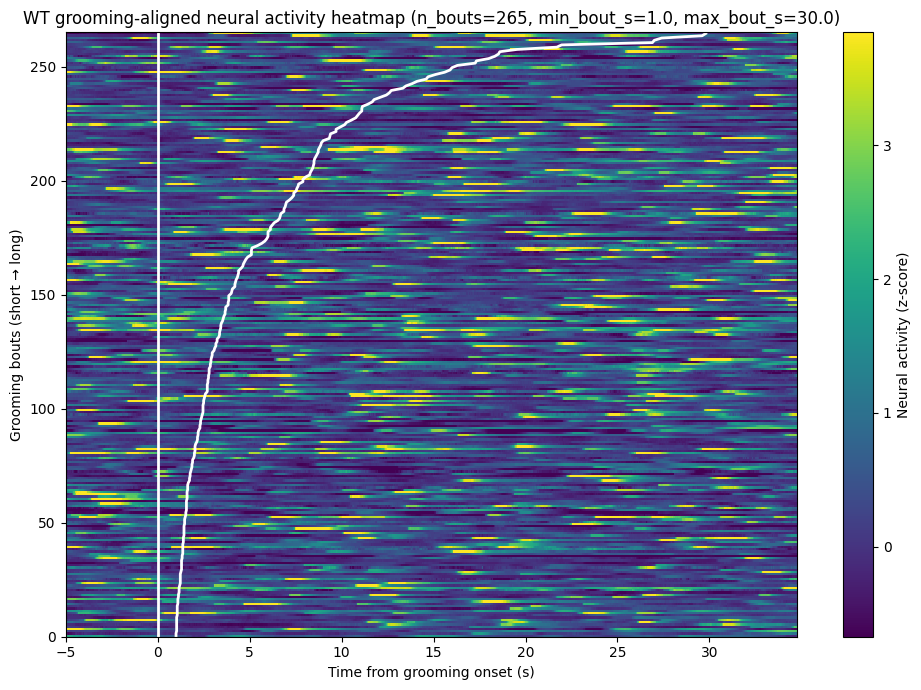

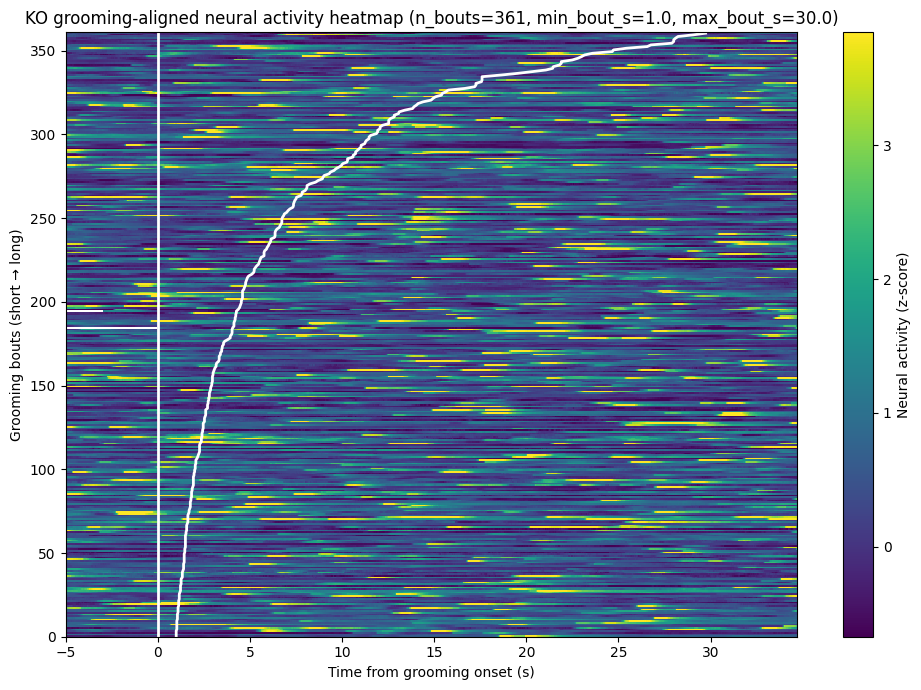


WT (END-aligned) windowed NA summary (mice as n)
  End: -10 to -7.5: n=7 | mean=0.529 | sem=0.054
  End: -7.5 to -5: n=7 | mean=0.580 | sem=0.026
  End: -5 to -2.5: n=7 | mean=0.630 | sem=0.029
  End: -2.5 to 0: n=7 | mean=0.587 | sem=0.044
  End: 0 to 2.5: n=7 | mean=0.495 | sem=0.022
  End: 2.5 to 5: n=7 | mean=0.527 | sem=0.054
  End: 5 to 7.5: n=7 | mean=0.501 | sem=0.045
  End: 7.5 to 10: n=7 | mean=0.616 | sem=0.053

KO (END-aligned) windowed NA summary (mice as n)
  End: -10 to -7.5: n=8 | mean=0.627 | sem=0.045
  End: -7.5 to -5: n=8 | mean=0.615 | sem=0.037
  End: -5 to -2.5: n=8 | mean=0.632 | sem=0.046
  End: -2.5 to 0: n=8 | mean=0.654 | sem=0.046
  End: 0 to 2.5: n=8 | mean=0.687 | sem=0.038
  End: 2.5 to 5: n=8 | mean=0.652 | sem=0.036
  End: 5 to 7.5: n=8 | mean=0.591 | sem=0.039
  End: 7.5 to 10: n=8 | mean=0.619 | sem=0.059


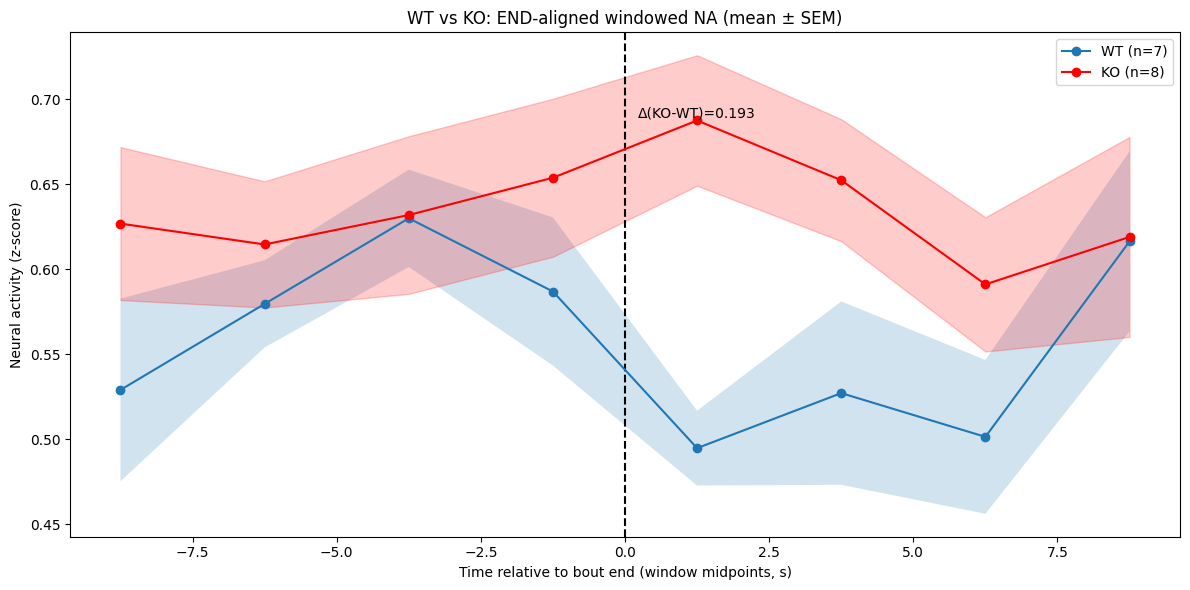


WT vs KO (Welch t-test)
  End: -10 to -7.5: WT=0.529, KO=0.627, p=0.1873
  End: -7.5 to -5: WT=0.580, KO=0.615, p=0.4534
  End: -5 to -2.5: WT=0.630, KO=0.632, p=0.9726
  End: -2.5 to 0: WT=0.587, KO=0.654, p=0.3125
  End: 0 to 2.5: WT=0.495, KO=0.687, p=0.001148  *Significant*
  End: 2.5 to 5: WT=0.527, KO=0.652, p=0.08004  ~Almost significant~
  End: 5 to 7.5: WT=0.501, KO=0.591, p=0.1603
  End: 7.5 to 10: WT=0.616, KO=0.619, p=0.9744

Within-group comparisons (WT (END-aligned)) vs End: -2.5 to 0
  End: -10 to -7.5 vs End: -2.5 to 0: Δ=-0.058, p=0.2055
  End: -7.5 to -5 vs End: -2.5 to 0: Δ=-0.007, p=0.8855
  End: -5 to -2.5 vs End: -2.5 to 0: Δ=0.043, p=0.4368
  End: 0 to 2.5 vs End: -2.5 to 0: Δ=-0.092, p=0.08316  ~Almost significant~
  End: 2.5 to 5 vs End: -2.5 to 0: Δ=-0.060, p=0.4388
  End: 5 to 7.5 vs End: -2.5 to 0: Δ=-0.085, p=0.2345
  End: 7.5 to 10 vs End: -2.5 to 0: Δ=0.029, p=0.6387

Within-group comparisons (KO (END-aligned)) vs End: -2.5 to 0
  End: -10 to -7.5 vs End

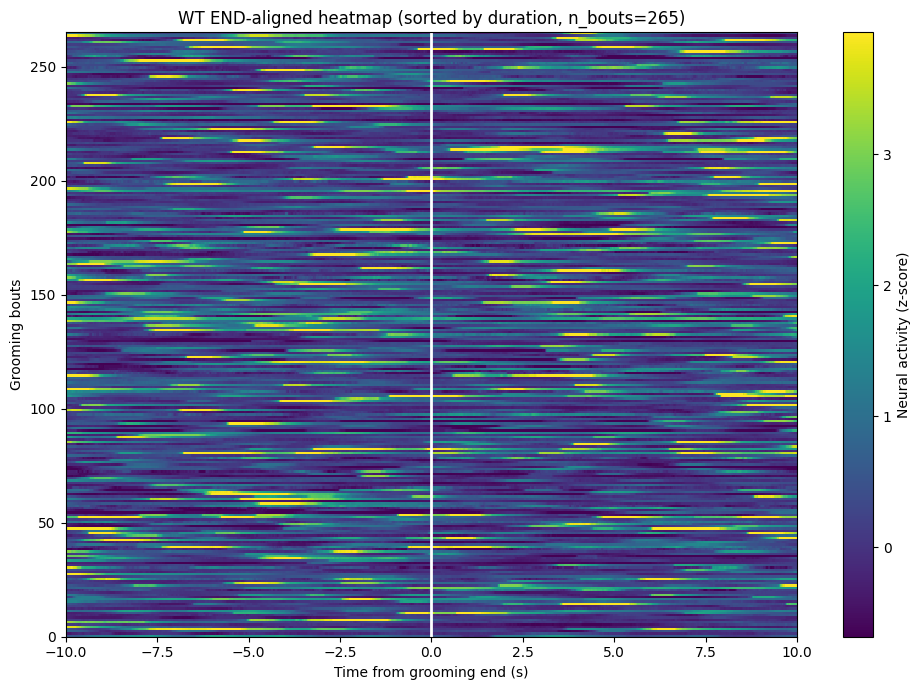

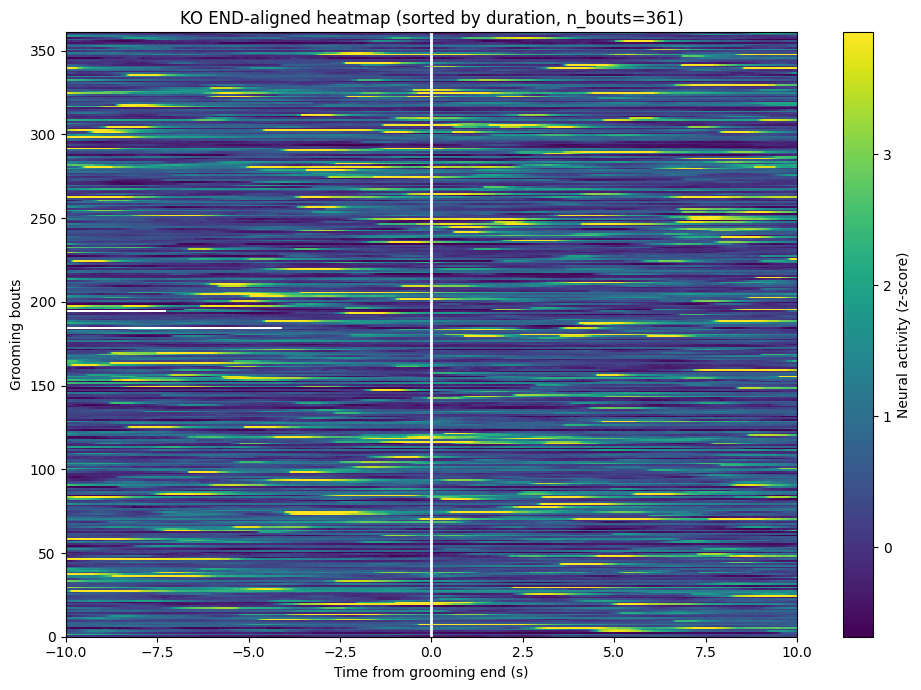

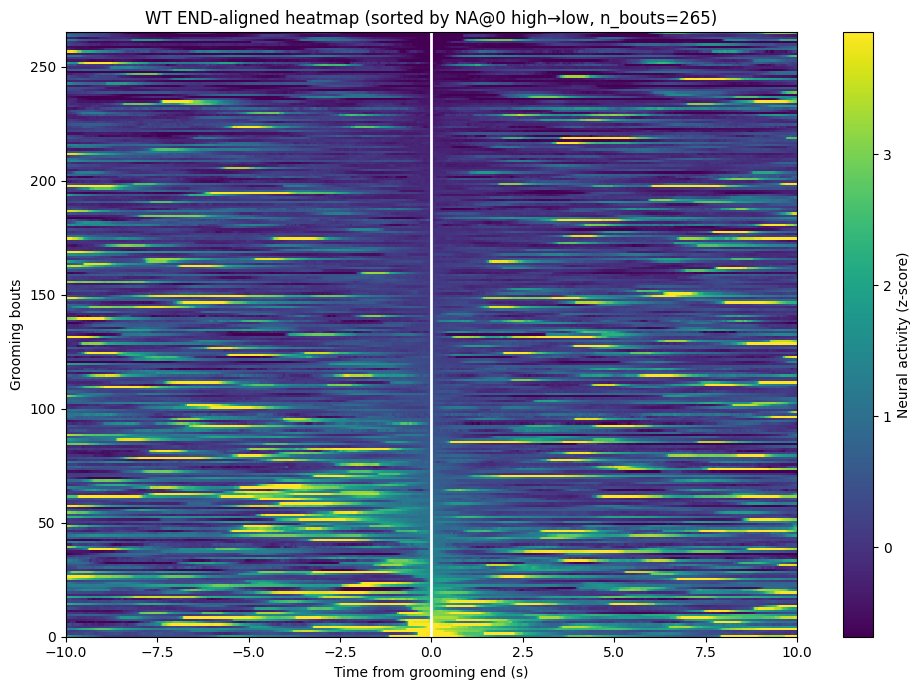

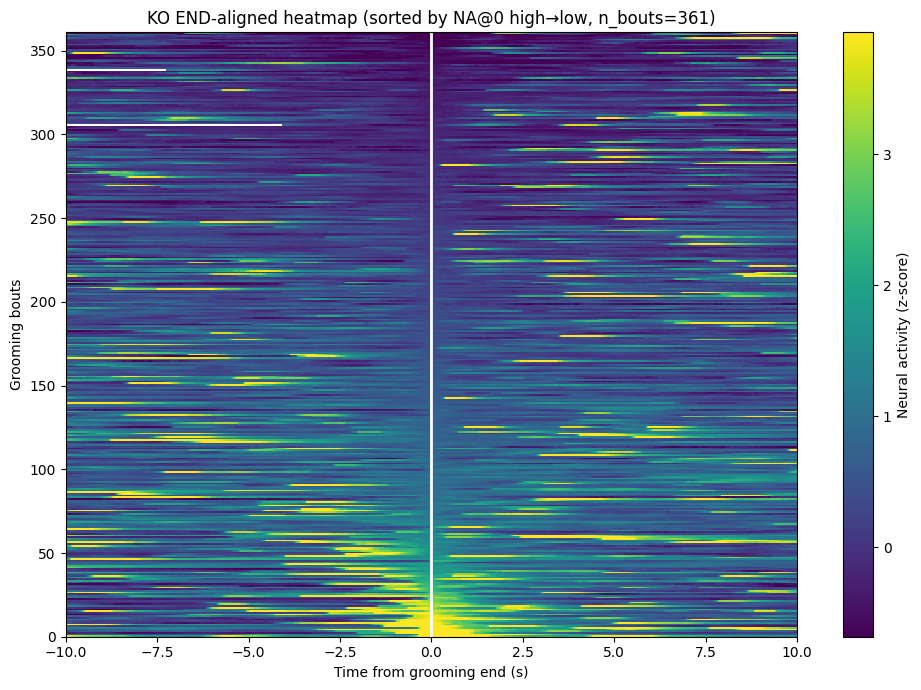

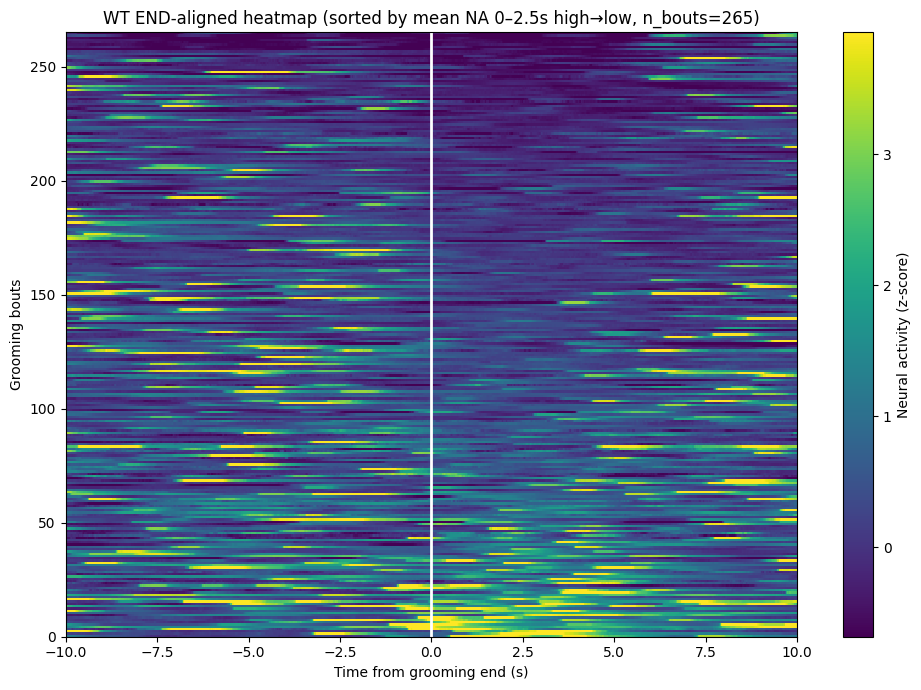

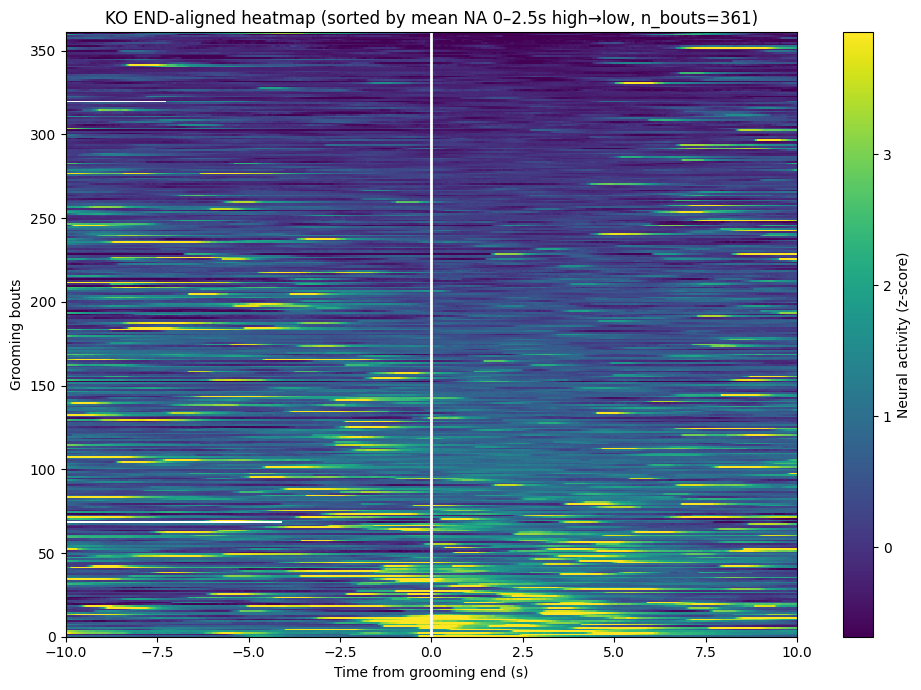

In [ ]:
if __name__ == "__main__":

    exps = load_experiments(DATA_FOLDER)
    print(f"Loaded experiments: {len(exps)}")

    # ---- SANITY CHECK: raw grooming annotations ----
    for exp in exps:
        print(
            exp.Mouse_id,
            "raw grooming bouts:",
            len(exp.Grooming_annotations)
        )

    groups = group_by_sapap_wt_ko(exps)
    print("Collapsed groups:", {k: len(v) for k, v in groups.items()})

    # ---- PRINT BOUT LENGTH SUMMARY AT TOP ----
    for label in ["WT", "KO"]:
        if label not in groups:
            continue
        n_total, n_0_2, n_2_6, n_6_10, n_10p = bout_length_summary(
            groups[label],
            FRAME_RATE,
            min_bout_s=MIN_BOUT_S,
            max_bout_s=MAX_BOUT_S,
        )
        print(
            f"{label}: n_bouts={n_total} | "
            f"0–2s: {n_0_2} | "
            f"2–6s: {n_2_6} | "
            f"6–10s: {n_6_10} | "
            f"≥10s: {n_10p}"
        )

    # ==========================================================
    # WINDOWED NA SUMMARY + STATS (WT vs KO, and within-group)
    # ==========================================================
    if "WT" in groups and "KO" in groups:
        summ_WT, pm_WT = summarize_activity_by_windows(
            groups["WT"], FRAME_RATE, WINDOWS, min_bout_s=MIN_BOUT_S
        )
        summ_KO, pm_KO = summarize_activity_by_windows(
            groups["KO"], FRAME_RATE, WINDOWS, min_bout_s=MIN_BOUT_S
        )

        print_window_summary("WT", summ_WT)
        print_window_summary("KO", summ_KO)

        # Between groups (WT vs KO for each window)
        compare_groups(pm_WT, pm_KO)

        # Within groups (paired comparisons vs a reference window)
        REF = "5sec Pre-Bout Start"
        compare_within_group(pm_WT, REF, group_label="WT")
        compare_within_group(pm_KO, REF, group_label="KO")


    else:
        # Fallback: print whatever exists (no stats)
        for label in ["WT", "KO"]:
            if label not in groups:
                continue
            summ, _ = summarize_activity_by_windows(
                groups[label], FRAME_RATE, WINDOWS, min_bout_s=MIN_BOUT_S
            )
            print_window_summary(label, summ)

    # ==========================================================
    # HEATMAPS + BOUT LENGTH SUMMARY
    # ==========================================================
    results = {}
    for label in ["WT", "KO"]:
        if label not in groups:
            print(f"{label}: no experiments found.")
            results[label] = (None, None, None)
            continue

        mat, t, lengths_s = build_bout_heatmap_matrix(
            groups[label],
            FRAME_RATE,
            PRE_TIME_S,
            POST_EXTRA_S,
            min_bout_s=MIN_BOUT_S,
            max_bout_s=MAX_BOUT_S,
        )

        if mat is None:
            print(
                f"{label}: no valid grooming bouts after filtering "
                f"(min_bout_s={MIN_BOUT_S}, max_bout_s={MAX_BOUT_S})."
            )
            results[label] = (None, None, None)
            continue

        results[label] = (mat, t, lengths_s)

    # Determine vmin/vmax (shared scale if requested)
    vmin_use, vmax_use = VMIN, VMAX
    if vmin_use is None and vmax_use is None and USE_SHARED_AUTOSCALE:
        vmin_use, vmax_use = compute_shared_vmin_vmax(
            [results.get("WT", (None, None, None))[0], results.get("KO", (None, None, None))[0]],
            percentiles=AUTOSCALE_PERCENTILES,
        )

    # Plot once per group
    for label in ["WT", "KO"]:
        mat, t, lengths_s = results.get(label, (None, None, None))
        if mat is None:
            continue

        plot_heatmap(
            mat,
            t,
            lengths_s,
            title=f"{label} grooming-aligned neural activity heatmap (n_bouts={mat.shape[0]}, min_bout_s={MIN_BOUT_S}, max_bout_s={MAX_BOUT_S})",
            vmin=vmin_use if VMIN is None else VMIN,
            vmax=vmax_use if VMAX is None else VMAX,
            use_step=False,  # set True if you prefer a staircase edge
        )

    # ==========================================================
    # END-ALIGNED WINDOWED NA SUMMARY + STATS
    # (relative to bout END: -10:-5, -5:0, 0:5, 5:10)
    # ==========================================================
    if "WT" in groups and "KO" in groups:
        end_summ_WT, end_pm_WT = summarize_activity_by_windows(groups["WT"], FRAME_RATE, END_WINDOWS, min_bout_s=MIN_BOUT_S)
        end_summ_KO, end_pm_KO = summarize_activity_by_windows(groups["KO"], FRAME_RATE, END_WINDOWS, min_bout_s=MIN_BOUT_S)

        print_window_summary("WT (END-aligned)", end_summ_WT)
        print_window_summary("KO (END-aligned)", end_summ_KO)

        # ---- LINE GRAPH (WT vs KO) ----
        plot_end_window_linegraph(
            end_summ_WT,
            end_summ_KO,
            END_WINDOWS,
            title="WT vs KO: END-aligned windowed NA (mean ± SEM)",
            highlight_window=(0.0, 2.5),
        )

        # Between groups (WT vs KO for each end-window)
        compare_groups(end_pm_WT, end_pm_KO)

        # Within groups (paired comparisons vs a reference end-window)
        #END_REF = "End: -5 to 0"
        END_REF = "End: -2.5 to 0"
        compare_within_group(end_pm_WT, END_REF, group_label="WT (END-aligned)")
        compare_within_group(end_pm_KO, END_REF, group_label="KO (END-aligned)")

    else:
        # Fallback: print whatever exists (no stats)
        for label in ["WT", "KO"]:
            if label not in groups:
                continue
            end_summ, _ = summarize_activity_by_windows(
                groups[label], FRAME_RATE, END_WINDOWS, min_bout_s=MIN_BOUT_S
            )
            print_window_summary(f"{label} (END-aligned)", end_summ)

    # ==========================================================
    # END-ALIGNED HEATMAPS (±10s around bout end)
    #   1) sorted by duration (short -> long)
    #   2) sorted by NA@0 (high -> low)
    # ==========================================================

    end_results = {}

    for label in ["WT", "KO"]:
        if label not in groups:
            end_results[label] = {"dur": None, "na0": None, "mean02": None}
            continue

        # (1) sorted by duration
        mat_dur, t_end, dur_s, na0, mean_post = build_end_aligned_heatmap_matrix(
            groups[label],
            FRAME_RATE,
            END_ALIGN_PRE_S,
            END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S,
            max_bout_s=MAX_BOUT_S,
            sort_by="duration",
        )

        # (2) sorted by NA@0
        mat_na0, t_end2, dur_s2, na0_2, mean_post2 = build_end_aligned_heatmap_matrix(
            groups[label],
            FRAME_RATE,
            END_ALIGN_PRE_S,
            END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S,
            max_bout_s=MAX_BOUT_S,
            sort_by="na0",
        )

        # (3) sorted by mean NA in 0–2.5 s after bout end
        mat_m02, t_end3, dur_s3, na0_3, mean_post3 = build_end_aligned_heatmap_matrix(
            groups[label],
            FRAME_RATE,
            END_ALIGN_PRE_S,
            END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S,
            max_bout_s=MAX_BOUT_S,
            sort_by="mean_post",
            sort_window=(0.0, 5),
        )

        # store everything
        end_results[label] = {
            "dur": mat_dur,
            "na0": mat_na0,
            "mean02": mat_m02,
            "t": t_end,  # same for all three
        }


    # Use same vmin/vmax logic as your other heatmaps
    end_vmin_use, end_vmax_use = VMIN, VMAX
    if end_vmin_use is None and end_vmax_use is None and USE_SHARED_AUTOSCALE:
        mats_for_scale = []
        for label in ["WT", "KO"]:
            for key in ["dur", "na0", "mean02"]:
                m = end_results.get(label, {}).get(key, None)
                if m is not None:
                    mats_for_scale.append(m)


        end_vmin_use, end_vmax_use = compute_shared_vmin_vmax(
            mats_for_scale,
            percentiles=AUTOSCALE_PERCENTILES,
        )

    # ==========================================================
    # Plot END-aligned heatmaps
    #   1) sorted by duration (WT → KO)
    #   2) sorted by NA@0 (WT → KO)
    # ==========================================================

    # ---- 1) SORTED BY DURATION ----
    for label in ["WT", "KO"]:
        t_end = end_results.get(label, {}).get("t", None)
        mat_dur = end_results.get(label, {}).get("dur", None)

        if mat_dur is None:
            continue

        plot_end_aligned_heatmap(
            mat_dur,
            t_end,
            title=f"{label} END-aligned heatmap (sorted by duration, n_bouts={mat_dur.shape[0]})",
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )

    # ---- 2) SORTED BY NA@0 (high → low) ----
    for label in ["WT", "KO"]:
        t_end = end_results.get(label, {}).get("t", None)
        mat_na0 = end_results.get(label, {}).get("na0", None)

        if mat_na0 is None:
            continue

        plot_end_aligned_heatmap(
            mat_na0,
            t_end,
            title=f"{label} END-aligned heatmap (sorted by NA@0 high→low, n_bouts={mat_na0.shape[0]})",
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )

    # ---- 3) SORTED BY mean NA in 0–2.5s (high → low) ----
    for label in ["WT", "KO"]:
        t_end = end_results.get(label, {}).get("t", None)
        mat_mean02 = end_results.get(label, {}).get("mean02", None)

        if mat_mean02 is None:
            continue

        plot_end_aligned_heatmap(
            mat_mean02,
            t_end,
            title=f"{label} END-aligned heatmap (sorted by mean NA 0–2.5s high→low, n_bouts={mat_mean02.shape[0]})",
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )

